# **Preprocessing**

### **Eksplorasi Data**

Pada tahapan ini saya akan melakukan beberapa persiapan dan juga mencoba memeahami isi dari data tersebut mulai dari banyaknya data pada setiap label dan lain lain.

In [2]:
# menyiapkan library
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
import re
import string

lalu disini saya melakukan importing pada dataset untuk mengetahui isi dari data tersebut

In [3]:
# melakukan pengambilan data
df = pd.read_csv("TABEL DATA LATIH HATESPEECH RISET.xlsx - Sheet1.csv")

# melihat data
df.head()

,username,comment,label
0,dxndelin,@amyliarm lingkunganmu keknya punya pemahaman ...,Netral
1,__succiduous,Udah jelek brengsek pula,Ras
2,KemenagMempawah,Lucunya penghuni negeri ini selalu di hiasi da...,Agama
3,1stKOREANguy1,"Yang jelek + miskin udah pasti bukan Kristen ,...",Ras
4,newsutdofficial,@MurtadhaOne1 Mereka memanfaatkan kebodohan ka...,Agama


Lalu kita akan coba telusuri banyaknya data untuk setiap labelnya. Jikalau tidak seimbang maka nantinya akan saya proses lagi. Karena kalau label tidak seimbang, maka akan berpotensi overfitting. Mengapa overfitting ? dikarenakan model akan lebih cenderung belajar pada data yang paling banyak, sehingga dia akan sulit mengenali pada data dengan class yang jumlahnya sedikit. 

In [4]:
# banyaknya data pada setiap class
df.label.value_counts()

label
Netral    836
Ras       601
Agama     563
Name: count, dtype: int64

Setelah saya lakukan analisa ternyata keseimbangan datanya sudah cukup bagus

### **Seleksi Fitur**

Pada tahapan ini kita akan mencoba menyeleksi fitur pada data kita. Kita akan menghapus untuk fitur yang tidak diperlukan. Setelah melihat datanya saya bisa menentukan bahwa fitur yang kita perlukan hanya comment dan label saja. Comment yang akan menjadi data x nya nanti dan label sebagai data y nya nanti

In [5]:
# menghilangkan fitur
df.drop(columns="username", inplace=True)

# mlihat data
df.head()

,comment,label
0,@amyliarm lingkunganmu keknya punya pemahaman ...,Netral
1,Udah jelek brengsek pula,Ras
2,Lucunya penghuni negeri ini selalu di hiasi da...,Agama
3,"Yang jelek + miskin udah pasti bukan Kristen ,...",Ras
4,@MurtadhaOne1 Mereka memanfaatkan kebodohan ka...,Agama


### **Cleaning**

**Nilai yang Hilang**

kita akan mencari apakah ada data yang hilang. Untuk memastikan bahwa data ini tidak ada yang hilang. **Mengapa harus di cek lagi ?** karena jika benar benar ada data yang hilang, maka akan berpotensi **kesalahpahaman oleh model**. Misal pada text terisi Nan (karena tidak ada nilainya) maka model akan mengira kalau text tersebut memiliki text yang berisi "Nan"

In [6]:
# jumlah nilai hilang jenis Nan
df.isna().sum()

comment    3
label      4
dtype: int64

kita dapat melihta kalau ada data kosong di kolom comment sebanyak 3 data dan data kosong di label ada 4 data. Yang kita lakukan adalah **mengdrop / menghilangkan data yang kosong** ini. Kenapa kok dihilangkan bukan di cari rata rata atau lainnya. Karena data text pada comment itu unik untuk setiap datanya. Maka tidak bisa dilakukan pencarian mean, modus, atau lain lain.

In [7]:
# melihat data unik pada label
df.label.unique()

array(['Netral', 'Ras', 'Agama', nan], dtype=object)

In [8]:
# menghilangkan data kosong
df.dropna(inplace=True)

# melihat banyak data kosong
df.isna().sum()

comment    0
label      0
dtype: int64

**Data yang Terduplikasi**

kita akan mencari apakah ada data yang terduplikasi atau tidak. **mengapa kita perlu mencari apakah ada data yang duplikasi** ? karena jika data yang terduplikasi ini dibiarkan maka akan **menimbulkan overfitting** karena model akan **cenderung menghafal** pada data yang terduplikasi. Jikalau model ini menghafal maka yang terjadi dia akan **kesulitan untuk menebak data yang baru**

In [9]:
# melihat data yang terduplikasi
df[df.comment.duplicated()]

,comment,label
143,"@VIVAcoid Sudahlah,Dia mnjabat sbg menteri saj...",Netral
144,@banjarbase Agama jgn dijadikan tolak ukur lag...,Netral
269,@yonkpaws Jelek klodia ðŸ˜”ðŸ˜”,Ras
387,gua kok ngerekam suara gue jelek amat anjir bi...,Agama
398,Ini contoh Islam yg ga bener + contoh kristen ...,Agama
...,...,...
1728,IKN Potret Kemajuan,Netral
1730,IKN Potret Kemajuan,Netral
1733,IKN Potret Kemajuan,Netral
1811,IKN Potret Kemajuan,Netral


di atas kita dapat melihat kalau **ada data yang terduplikasi**. Maka selanjutnya kita perlu menghilangkan salah satu data yang terduplikasi ini. Kita dapat menggunakan function yang ada di pandas

In [10]:
# menghilangkan data yang terduplikasi
df.drop_duplicates(inplace=True)

# melihat banyaknya data yang terduplikasi
df[df.comment.duplicated()]

,comment,label
387,gua kok ngerekam suara gue jelek amat anjir bi...,Agama
458,@RazmanZakaria60 apa sumbangan PAS kepada nega...,Agama
477,@Motty_hang yang benci FPI PKI dan kaum munafikun,Agama
491,@souIsinlove kpop k nya kafir jahat setan wall...,Agama
512,"gausah senyum kau didepan ku kntl, jelek kau b...",Ras
600,"@kompascom Maka, oleh sebab itu bertindaklah s...",Ras
1671,@apoycuy Tokoh agama di Papua kecam penyeranga...,Ras


### **Train Test Split**

Pada tahapan ini kita akan melakukan splitting data menjadi data yang digunakan khusus untuk train dan data yang digunakan khusus untuk test. Mengapa hal ini perlu dilakukan, karena agar kita dapat melihat performa model kita melalui data yang baru (data test)

In [11]:
# akan mengembalikan data yang sudah di split
def Train_Test_Split(x, y, random_seed=None, test_size=0.2):
    n = len(x) # banyak data

    # jika punya seed
    if random_seed:
        np.random.seed(random_seed)
    
    # banyak data test
    test_size = int(test_size * n)

    # menentukan index secara random
    indices = np.random.permutation(n)
    train_indices, test_indices = indices[test_size:], indices[:test_size]

    return x.iloc[train_indices], x.iloc[test_indices], y.iloc[train_indices], y.iloc[test_indices]
# menentukan x dan y nya
x = df["comment"]
y = df["label"]

# splitting pada data kita
X_train, X_test, y_train, y_test  = Train_Test_Split(x, y, random_seed=42)

# melihat isi data train
X_train

1796    Indonesia Negara Hukum\r\n Assalamuâ€™alaikum\...
908     Ã¢â‚¬Å“Tergantung interpretasi masing-masing i...
575     Terbukti benar hrus dipercaya benar, tak jelas...
1697    menurutku penyakit kita bukan pada pakaian dan...
1475    @WagimanDeep212_ Berbalut agama makan duit don...
                              ...                        
1179    @maman1965 Berusaha menghormati adat istiadat ...
1343    @ZacZakirin13 @syazreenaaa Tapi menteri agama ...
906     @OposisiCerdas Murtad aja keles susah bgt. Toh...
1510    WARTAWAN RASMI LAMAN REFORMASI: TIK TOK KHALID...
1175    PENGURUS BARU HMI dari BANDUNG pakai KALUNG SA...
Name: comment, Length: 1557, dtype: object

### **Case Folding**

Pada tahapan ini kita akan menghilangkan karakter karakter yang **tidak memiliki makna dalam segi bahasa** yang ada pada data comment. Karakter seperti tag, hashtag, link, emoji, dan lain lain. Karena karakter jenis ini terlalu unik maka kita perlu menghilkangkannya. Karakter yang **terlalu unik umumnya tidak memiliki pola**.

# akan mengembalikan text yang sudah di case
def case_folding(text):
    # menghilangkan tag
    text = re.sub(r"@[A-Za-z0-9_]+", "", text)
    # menghilangkan hashtag
    text = re.sub(r"#\w+", "", text)
    # menghilangkan link
    text = re.sub(r"https?://\S+", "", text)
    # menghilangkan newline atau enter
    text = re.sub(r"\n+", "", text)
    # menghilangkan \r
    text = re.sub(r"\r+", "", text)
    # menghilangkan nomer
    text = re.sub(r"\d+", "", text)

    # menghilangkan simbol
    text = text.translate(str.maketrans("", "", string.punctuation))

    # menghilangkan emoji
    emoji_pattern = re.compile("["
                               u"\U0001F600-\U0001F64F"
                               u"\U0001F300-\U0001F5FF"
                               u"\U0001F680-\U0001F6FF"
                               u"\U00010000-\U0010ffff"
                               "]+", flags=re.UNICODE)
    text = emoji_pattern.sub(r"", text).lower()

    # menghilangkan karakter diluar latin
    qwerty = "abcdefghijklmnopqrstuvwxyz "
    text = "".join([letter for letter in text if letter in qwerty])

    # memperkecil huruf
    return text

# mengimplementasikann untuk setiap doc
X_train = X_train.apply(case_folding)
X_train

### **Tokenize**

Pada tahapan ini kita akan melakukan **pemisahan** untuk setiap document nya menjadi **list kata**. Tujuannya adalah kata ini akan menjadi fitur nantinya dalam pembobotan kata

In [12]:
# akan mengembalikan documen yang sudah di tokenize
def tokenize(text):
    return word_tokenize(text)

# mengimplementasikan untuk setiap doc
X_train = X_train.apply(tokenize)
X_train

1796    [Indonesia, Negara, Hukum, Assalamuâ€™alaikum,...
908     [Ã¢â‚¬Å, “, Tergantung, interpretasi, masing-m...
575     [Terbukti, benar, hrus, dipercaya, benar, ,, t...
1697    [menurutku, penyakit, kita, bukan, pada, pakai...
1475    [@, WagimanDeep212_, Berbalut, agama, makan, d...
                              ...                        
1179    [@, maman1965, Berusaha, menghormati, adat, is...
1343    [@, ZacZakirin13, @, syazreenaaa, Tapi, menter...
906     [@, OposisiCerdas, Murtad, aja, keles, susah, ...
1510    [WARTAWAN, RASMI, LAMAN, REFORMASI, :, TIK, TO...
1175    [PENGURUS, BARU, HMI, dari, BANDUNG, pakai, KA...
Name: comment, Length: 1557, dtype: object

### **Normalize**

Pada proses ini kita akan mengubah kata yang **tidak baku menjadi kata baku / kata yang umum menjadi kata yang umum**. Seperti singkatan singkatan menjadi kata yang aslinya. Tujuannya adalah agar menjadikan sama makna yang disingkat dengan yang tidak disingkat

In [13]:
# kata yang harus dinormalize
norm_word = {
    "emg" : "memang",
    "saiz" : "size",
    "cino" : "cina",
    "jowo" : "jawa",
    "kite" : "kita",
    "lg" : "lagi",
    "aj" : "aja",
    "yg" : "yang",
    "pdhl" : "padahal",
    "napa" : "kenapa",
    "dh" : "sudah",
    "udh" : "sudah",
    "tdk" : "tidak",
    "sm" : "sama",
    "ga" : "tidak",
    "bgt" : "banget",
    "mentri" : "menteri",
    "embantu" : "membantu",
    "dlm" : "dalam",
    "bdang" : "bidang",
    "msh" : "masih",
    "ampe" : "sampai",
    "ky" : "kaya",
    "nnya" : "tanya",
    "krn" : "karena",
    "jir" : "anjing",
    "ajg" : "anjing",
    "anjir" : "anjing",
    "gak" : "tidak",
    "ak" : "aku",
    "dasr" : "dasar",
    "lgsg" : "langsung",
    "skrg" : "sekarang",
    "gw" : "gua",
    "w" : "gua",
    "engga" : "tidak",
    "dgn" : "dengan",
    "orng" : "orang",
    "org" : "orang",
    "ni" : "ini",
    "jgn" : "jangan",
    "mbahas" : "bahas",
    "krna" : "karena",
    "ma" : "sama",
    "sblm" : "sebelum",
    "tp" : "tapi",
    "sbg" : "sebagai"
}

# melakukan normalisasi
def normalize(text):
    return [norm_word[word] if word in norm_word else word for word in text]

# mengimplementasikan untuk setiap doc
X_train = X_train.apply(normalize)
X_train

1796    [Indonesia, Negara, Hukum, Assalamuâ€™alaikum,...
908     [Ã¢â‚¬Å, “, Tergantung, interpretasi, masing-m...
575     [Terbukti, benar, hrus, dipercaya, benar, ,, t...
1697    [menurutku, penyakit, kita, bukan, pada, pakai...
1475    [@, WagimanDeep212_, Berbalut, agama, makan, d...
                              ...                        
1179    [@, maman1965, Berusaha, menghormati, adat, is...
1343    [@, ZacZakirin13, @, syazreenaaa, Tapi, menter...
906     [@, OposisiCerdas, Murtad, aja, keles, susah, ...
1510    [WARTAWAN, RASMI, LAMAN, REFORMASI, :, TIK, TO...
1175    [PENGURUS, BARU, HMI, dari, BANDUNG, pakai, KA...
Name: comment, Length: 1557, dtype: object

### **Menghilangkan Stopwords**

Pada tahapan ini kita akan menyeleksi kata tertentu. Kita akan **menghilangkan kata yang tidak memiliki makna secara independen**. **Mengapa harus dihilangkan ?** dikarenakan nantinya yang akan **dilakukan pembobotan** kata akan memerlukan makna yang independen pada setiap fitur nya. Jika maknanya itu dependen dan terikat pada kata yang lainnya maka akan berbeda beda maknanya. Jika makna beda, maka tidak ada pola nanti datanya. Contoh konjungsi, kata penjelas, dan lain lain.

In [14]:
# kata yang harus di stop
stopw = stopwords.words("indonesian")

# mengembalikan kata yang sudah di stop
def stopword(text):
    return [word for word in text if word not in stopw and len(word) >=2 ]

# mengimplementasikan untuk setiap doc
X_train = X_train.apply(stopword)
X_train

1796    [Indonesia, Negara, Hukum, Assalamuâ€™alaikum,...
908     [Ã¢â‚¬Å, Tergantung, interpretasi, individu, k...
575     [Terbukti, hrus, dipercaya, salah, dipercaya, ...
1697    [menurutku, penyakit, pakaian, asesories, akar...
1475    [WagimanDeep212_, Berbalut, agama, makan, duit...
                              ...                        
1179    [maman1965, Berusaha, menghormati, adat, istia...
1343    [ZacZakirin13, syazreenaaa, Tapi, menteri, aga...
906     [OposisiCerdas, Murtad, aja, keles, susah, ban...
1510    [WARTAWAN, RASMI, LAMAN, REFORMASI, TIK, TOK, ...
1175    [PENGURUS, BARU, HMI, BANDUNG, pakai, KALUNG, ...
Name: comment, Length: 1557, dtype: object

### **Stemming**

Pada tahapan ini kita akan melakukan pengubahan kata kata menjadi kata dasarnya. Tujuannya adalah agar memperkecil variasinya sehingga model juga akan memahami bahwa kata yang belum dasar memiliki makna yang sama dengan kata dasarnya. Misal Penyanyi menjadi nyanyi, Pemahaman menjadi paham.

In [15]:
stemmer = StemmerFactory().create_stemmer()

def stemming(text):
    return [stemmer.stem(word) for word in text]

# mengimplementasikan untuk setiap doc
X_train = X_train.apply(stemming)
X_train

1796    [indonesia, negara, hukum, assalamu alaikum, u...
908     [, gantung, interpretasi, individu, kemari, ru...
575     [bukti, hrus, percaya, salah, percaya, salah, ...
1697    [turut, sakit, pakai, asesories, akar, budaya,...
1475    [wagimandeep212, balut, agama, makan, duit, do...
                              ...                        
1179    [maman1965, usaha, hormat, adat, istiadat, lok...
1343    [zaczakirin13, syazreenaaa, tapi, menteri, aga...
906     [oposisicerdas, murtad, aja, les, susah, bange...
1510    [wartawan, rasmi, laman, reformasi, tik, tok, ...
1175    [urus, baru, hmi, bandung, pakai, kalung, sali...
Name: comment, Length: 1557, dtype: object

**Kemunculan Data** 

Pada tahapan kita akan mencari kata yang paling sering disebut di setiap class

In [16]:
# data yang ingin dilabeli
labeled_data = X_train.to_frame()

# melabeli data
labeled_data["label"] = y_train

labeled_data

,comment,label
1796,"[indonesia, negara, hukum, assalamu alaikum, u...",Netral
908,"[, gantung, interpretasi, individu, kemari, ru...",Netral
575,"[bukti, hrus, percaya, salah, percaya, salah, ...",Agama
1697,"[turut, sakit, pakai, asesories, akar, budaya,...",Netral
1475,"[wagimandeep212, balut, agama, makan, duit, do...",Agama
...,...,...
1179,"[maman1965, usaha, hormat, adat, istiadat, lok...",Netral
1343,"[zaczakirin13, syazreenaaa, tapi, menteri, aga...",Netral
906,"[oposisicerdas, murtad, aja, les, susah, bange...",Agama
1510,"[wartawan, rasmi, laman, reformasi, tik, tok, ...",Agama


kata paling sering untuk class untuk class ras

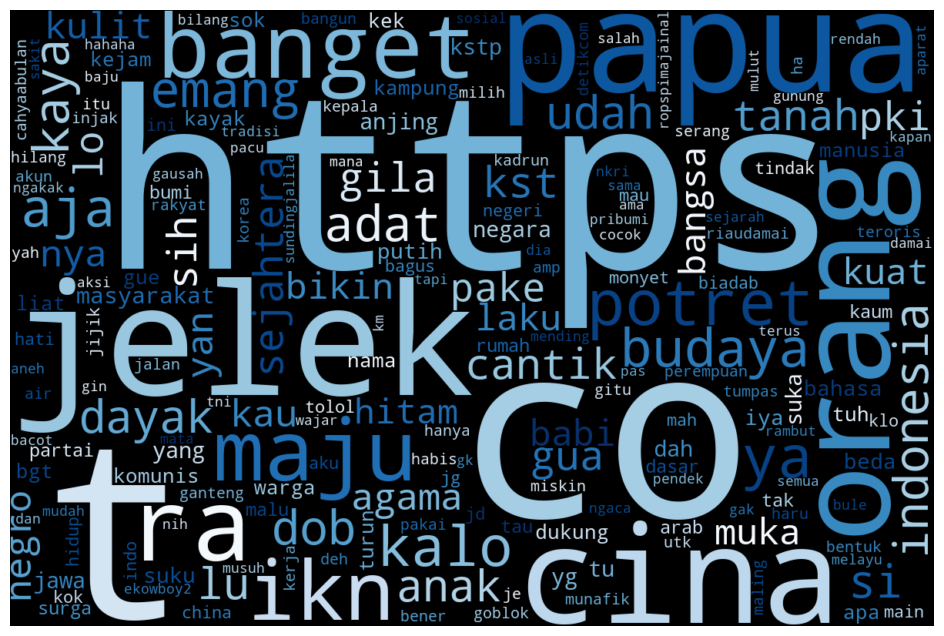

In [17]:
from wordcloud.wordcloud import WordCloud

# menampilkan data
def showing(wc):
    plt.figure(figsize=(12,8)) # ukuran
    plt.axis("off") 
    plt.imshow(wc, interpolation="bilinear")
    plt.show

# semua kata
allword = "".join([str(text).replace("'", "") for text in labeled_data.comment[labeled_data.label == "Ras"]])

# menyiapkan  komponen wordcloud
word_cloud = WordCloud(
    height=800,
    width=1200,
    collocations=False,
    colormap="Blues_r"
 ).generate(allword)

showing(word_cloud)

kata paling sering untuk class untuk class Agama

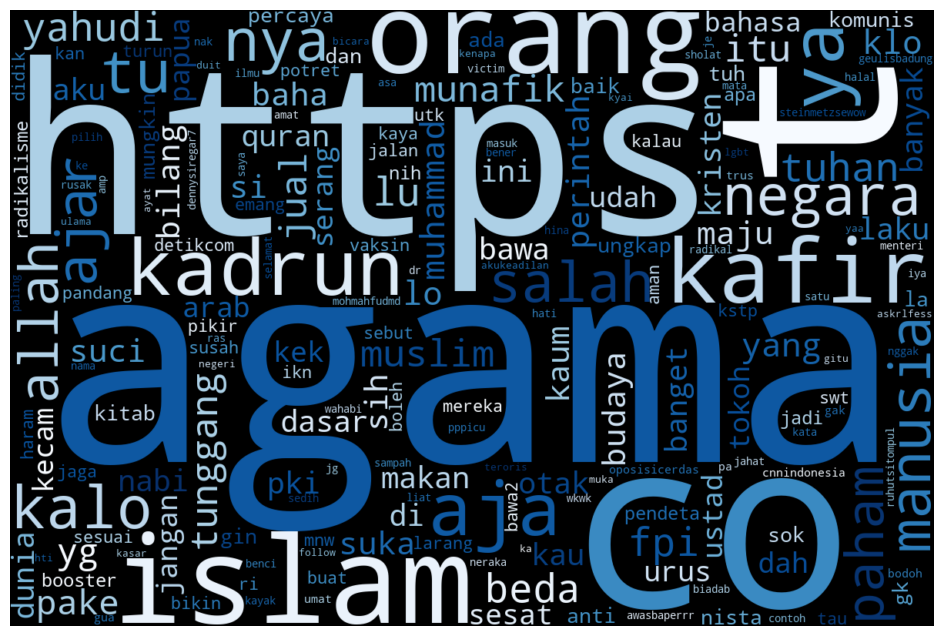

In [18]:
# menampilkan data
def showing(wc):
    plt.figure(figsize=(12,8)) # ukuran
    plt.axis("off") 
    plt.imshow(wc, interpolation="bilinear")
    plt.show

# semua kata
allword = "".join([str(text).replace("'", "") for text in labeled_data.comment[labeled_data.label == "Agama"]])

# menyiapkan  komponen wordcloud
word_cloud = WordCloud(
    height=800,
    width=1200,
    collocations=False,
    colormap="Blues_r"
 ).generate(allword)

showing(word_cloud)

kata paling sering untuk class untuk class netral

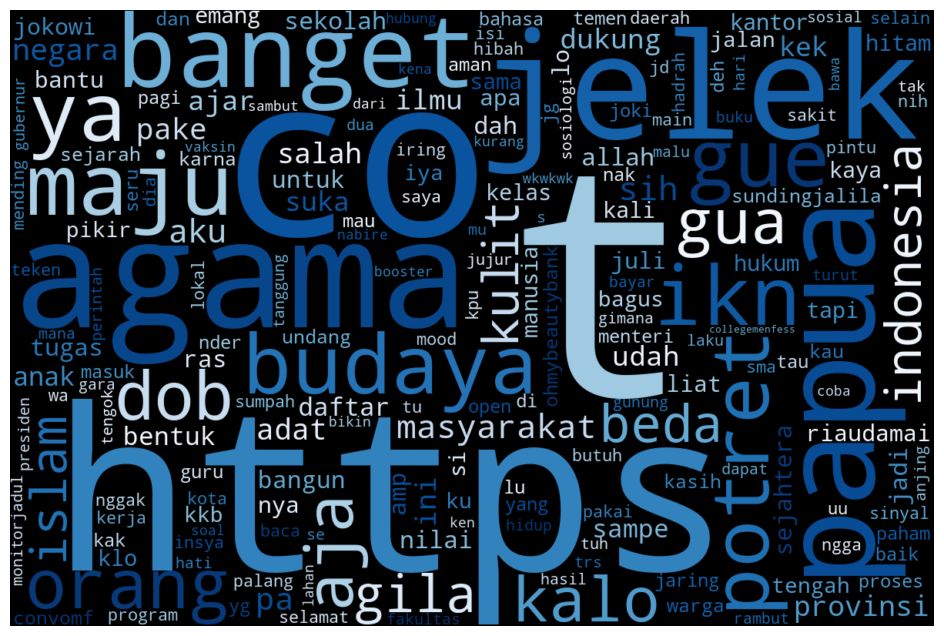

In [19]:
# menampilkan data
def showing(wc):
    plt.figure(figsize=(12,8)) # ukuran
    plt.axis("off") 
    plt.imshow(wc, interpolation="bilinear")
    plt.show

# semua kata
allword = "".join([str(text).replace("'", "") for text in labeled_data.comment[labeled_data.label == "Netral"]])

# menyiapkan  komponen wordcloud
word_cloud = WordCloud(
    height=800,
    width=1200,
    collocations=False,
    colormap="Blues_r"
 ).generate(allword)

showing(word_cloud)

# **Pembobotan Kata**

### **Kalkulasi TF-IDF**

Pada tahapan ini kita akan melakukan perhitungan dalam **TFIDF** untuk nilai dari pembobotan kata berikut untuk tahapan tahapannya:
- Untuk tahapan awal kita akan melakukan perhitungan *term frequency* yaitu perhitungan **banyaknya term / jumlah kata** untuk suatu dokumen **dibanding** dengan **banyak kata** yang ada di dokumen tersebut. untuk rumus dari TF atau *term frequency* adalah **TF** = kata *t* diulang di document *d* / banyak kata di document *d* 
- Untuk tahapan selanjutnya adalah kita akan menghitung dari *inverse document frequency* yaitu perhitungan berapa **banyak dokumen** yang didalamnya terdapat **kata *t***. Untuk rumusnya dari IDF atau *inverse document frequency* adalah **IDF** = log10(banyak document / banyak document yang di dalamnya ada kata *t* )
- Lalu pada tahapan selanjutnya adalah kita akan melakukan perhitungan untuk ***pembobotan suatu kata*** dengan *TF-IDF*  yaitu gabungan *term frequency* dan *inverse document frequency*. Cara menggabungkannya adalah dengan mengkali nilai dari TF dan IDF nya. rumus dari *TF IDF* adalah **TFIDF** = TF * IDF
- Lalu kita akan menentukan *TF IDF* untuk setiap item
- Lalu untuk mempermudah hasil analisa akan dilakukan normalisasi untuk nilai tf idf

In [20]:
# Inisialisasi Class yang akan digunakan untuk kalkulasi TF-IDF
class TFIDFVectorizer:
    # Inisialisasi variable yang dibutuhkan untuk kalkulasi TF-IDF
    def __init__(self) -> None:
        # Inisialisasi variable untuk menampung array teks yang sudah ditokenisasi dalam bentuk dictionary.
        self.documents = {}

        # Inisialisasi variable untuk menampung array TF yang sudah dikalkulasi dengan format {index : {term : value, ...}}
        self.tf = {}

        # Inisialisasi variable untuk menampung array IDF yang sudah dikalkulasi dengan format {key : value}
        self.idf = {}
        self.idf_token = []

        # Inisialisasi variable untuk menampung array TF-IDF yang sudah dikalkulasi dengan format {index : {term : value, ...}}
        self.tfidf = {}

        # Inisialisasi variable untuk menampung hasil tertinggi dan terendah dalam array TFIDF untuk keperluan normalisasi TF-IDF
        self.max_tfidf = 0
        self.min_tfidf = 0

    # Kalkulasi frekuensi kemunculan tiap term didalam dokumen dengan rumus (Number of term appear in the document/total term in the document)
    def CalculateTermFrequence(self):
        for index, document in self.documents.items():
            self.tf[index] = {}
            for term in document:
                if term in self.tf[index]:
                    self.tf[index][term] += 1
                else:
                    self.tf[index][term] = 1
            self.tf[index] = {term: value/sum(self.tf[index].values()) for term, value in self.tf[index].items()}
    
    # Kalkulasi Inverse Document Frequency, yang dimana semakin kecil maka semakin sering muncul dengan rumus log(Total Documents/Number the term appear in all documents)
    def CalculateInverseDocumentFrequency(self):
        documents_length = len(self.documents)
        self.idf_token = set()

        for document in self.documents.values():
            self.idf_token.update(document)

        for token in self.idf_token:
            self.idf[token] = np.log(documents_length/sum(1 for doc in self.documents.values() if token in doc))
        
    # Kalkulasi TFIDF dengan rumus (TERM_ITF*Calculated_IDF_TERM)
    def CalculateTFIDF(self):
        for index, document in self.tf.items():
            self.tfidf[index] = {}
            for word, value in document.items():
                self.tfidf[index][word] = value*self.idf[word]
            
            for token in self.idf_token:
                if token not in self.tfidf[index]:
                    self.tfidf[index][token] = 0
        
        flattened_value = [value for doc in self.tfidf.values() for value in doc.values()]
        self.max_tfidf = max(flattened_value)
        self.min_tfidf = min(flattened_value)
        
        #for index, document in self.tfidf.items():
        #    print(document)
        #     self.tfidf = sorted(document.items(), key=lambda x:x[1])
    

    # Memanggil Semua Fungsi untuk train TFIDF yang akan digunakan di Model, dan digunakan untuk mengconvert (predict text(input)) menjadi Value TF-IDF
    def Train(self, documents = {}):
        self.documents = documents
        self.CalculateTermFrequence()
        self.CalculateInverseDocumentFrequency()
        self.CalculateTFIDF()
        
        return self.tfidf
    
    # Kalkulasi TFIDF Terhadap (predict text(input)) dengan IDF yang sudah dikalkulasi di fungsi train/IDF dari data train untuk menunjukkan keunikan setiapterm pada (predict text(input))
    def CalculatePredictTextTFIDF(self, document):
        tf = {}
        for word in document:
            if word in tf:
                tf[word]+=1
            else:
                tf[word]=1
        tf = {key: value/sum(tf.values()) for key, value in tf.items()}

        tfidf = {}
        for word, value in tf.items():
            if word in self.idf_token:
                tfidf[word] = value*self.idf[word]
        
        for token in self.idf_token:
                if token not in tfidf:
                    tfidf[token] = 0
                    
        return tfidf

In [21]:
# melakukan implementasi untuk setiap data
dict = X_train.to_dict()
vectorizer = TFIDFVectorizer()
Vectorized_X_train = pd.DataFrame(vectorizer.Train(dict))
print(vectorizer.CalculatePredictTextTFIDF(["indonesia", "negara", "hukum", "assalamualaikum"]))

{'indonesia': 0.897329014035109, 'negara': 0.9217386314260879, 'hukum': 1.238155224758907, '': 0, 'manusi': 0, 'sekala': 0, 'usaha': 0, 'anwar': 0, 'bonaleles': 0, 'tiktok': 0, 'tertib': 0, 'adat': 0, 'mud': 0, 'nightmare': 0, 'kass': 0, 'pke': 0, 'well': 0, 'pantas': 0, 't co nxpgifgiw8': 0, 'skinticfic': 0, 'yo': 0, 'funny': 0, 'sakerautm': 0, 't co wkjoqnhavx': 0, 'dlktatur': 0, 'jem': 0, 'ust': 0, 'kapir': 0, 'eeaalahh': 0, 'mbulukk': 0, 'better': 0, 'ferrykoto': 0, 'keuangannews id': 0, 't co bcjwm4w9jr': 0, 'sampuk': 0, 'bodok': 0, 'beda': 0, 'sex': 0, 'gimmick': 0, 'makin': 0, 't co ckdepkby7n': 0, 'privasi': 0, 'joeallan23': 0, 'tasyabbuh': 0, 'ngga': 0, 'jirat': 0, 'bedain': 0, 'mescid-i': 0, 'oleh': 0, 'hiding': 0, 'irenedyah': 0, 'dap': 0, 'lngsg': 0, 'jaga': 0, 'keilangan': 0, 'gula': 0, 'mungil': 0, 'menghornati': 0, 'lelaki': 0, 'wyuanwca': 0, 'mojokerto': 0, 'auto': 0, 'koto': 0, 'skripsi': 0, 'teken': 0, 'mba': 0, 'sarkum09110094': 0, 'besar': 0, 'adil': 0, 'jokowi': 0,

In [37]:
import numpy
import math

class KNN:
    def __init__(self) -> None:
        self.xtrain = {}
        self.ytrain = pd.DataFrame()
        self.ytest = {}
        self.distances = {}
        self.neighbor = 1

    def fit(self, xtrain, ytrain):
        self.xtrain = xtrain
        self.ytrain = ytrain

    def predict(self, document):
        self.ytest = document
        for index, doc in self.xtrain.items():
            distance = []
            for term, value in self.ytest.items():
                distance.append((value-doc[term])**2)
            self.distances[index] = sum(distance)
        return self.voting()
    
    def voting(self):
        sorted_distance = min(self.distances.items(), key=lambda x:x[1])
        return y_train.loc[sorted_distance[0]]
    
    # menampilkan akurasi, prrecision, recall, dan f1 score
    def metric(self, y_pred, y_true, label):
    
        n_label = len(label) # banyak label
        
        confusion_matrix = np.zeros((n_label, n_label)) # confusion matriks

        # menghitung masing masing cell
        for i in range(len(y_pred)):
            confusion_matrix[label.index(y_pred[i])][label.index(y_true[i])] += 1
        self.cm = confusion_matrix # menyimpan di object
        print(confusion_matrix)

        # menghitung akurasi model
        accuracy = np.sum([confusion_matrix[i][i] for i in range(n_label)]) / len(y_pred)

        # perhitungan precision
        for i in range(n_label):
            print("\nclass:", label[i])

            # menghitung precision
            precision = confusion_matrix[i][i] / np.sum([confusion_matrix[i][k] for k in range(n_label)])
            self.precision.append(precision)
            print("precision:", precision)

            # menghitung recall
            recall = confusion_matrix[i][i] / np.sum([confusion_matrix[k][i] for k in range(n_label)])
            self.recall.append(recall)
            print("recall:", recall)

            # menghitung f1 score
            f1score = (2 * precision * recall) / (precision + recall)
            self.f1score.append(f1score)
            print(f1score)
            
        print("\naccuracy:", accuracy)
                

knn = KNN()
knn.fit(Vectorized_X_train, y_train)
text = "Ras terkuat di jalan, no counterðŸ¤£"
text = tokenize(text)
text = normalize(text)
text = stopword(text)
text = stemming(text)

text = (vectorizer.CalculatePredictTextTFIDF(text))
knn.predict(text)

KeyboardInterrupt: 

In [40]:
test = np.array(["tanah", "itu", "basah"])

test.

AttributeError: 'numpy.ndarray' object has no attribute 'index'

In [ ]:
def cleaning(text):
    text = tokenize(text)
    text = normalize(text)
    text = stopword(text)
    text = stemming(text)   
    return text

predict = []

for x in X_test.iloc[:30]:
    x = cleaning(x)
    x = (vectorizer.CalculatePredictTextTFIDF(x))

    predict.append(knn.predict(x))

knn.metric(predict, y_test, np.unique(y_test))

IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

In [39]:
knn.metric(predict, y_test.to_numpy()[:30], np.unique(y_test))

AttributeError: 'numpy.ndarray' object has no attribute 'index'

### **Feature Selection**

Pada tahapan ini kita akan melakukan penyeleksian pada fitur lagi. **Mengapa kita perlu melakukan penyeleksian lagi ?** dikarenakan setelah melakukan perhitungan tf idf, masih ada yang harus diseleksi untuk membuat **performa model** menjadi **lebih baik** lagi. **term yang baik** adalah term yang **nilai tf idf** nya **tidak mendekati nol**, dikarenakan jika nilai tf idf yang mendekati nol, maka term itu sangat sekali jarang muncul dalam suatu dokumen. **Jika semakin jarang muncul** maka banyak item yang nilai tf idf nya nol sehingga data untuk term tersebut **tidak akan memiliki pola**. Oleh karena itu, kita dapat menghapus term tersebut. 

Tetapi sebelum melakukan itu, kita perlu untuk melakukan analisa untuk menemukan *threshold* (nilai tf idf minimal)

In [ ]:
# semua term / feature
terms = Vectorized_X_train.columns

# mencari document frequemcy
document_fre = {}
for term in terms:
    document_fre[term] = 0
    for doc in X_train:
        if term in doc:
            document_fre[term] += 1

document_fre

{'indonesia': 41,
 'negara': 39,
 'hukum': 11,
 'assalamualaikum': 1,
 'lestari': 6,
 'waris': 4,
 'budaya': 75,
 'benda': 6,
 'pantun': 2,
 'apresiasi': 3,
 'gawe': 1,
 'untunga': 1,
 'ba': 5,
 'ip': 1,
 'jilat': 4,
 'tonjol': 1,
 'um': 2,
 'eeaalahh': 1,
 'moyang': 1,
 'tmp': 1,
 'bible': 1,
 'pantas': 1,
 'bankek': 1,
 'bendung': 1,
 'bejat': 1,
 'silaturahmi': 1,
 'hafal': 1,
 'minat': 1,
 'bai': 1,
 'berangkat': 1,
 'okay': 1,
 'muda': 6,
 'subhanallah': 1,
 'pecat': 1,
 'otai': 1,
 'ayat': 5,
 'seoul': 1,
 'agam': 2,
 'keji': 5,
 'injil': 1,
 'tt': 1,
 'cucu': 2,
 'nutupin': 1,
 'member': 3,
 'gtkan': 1,
 'loe': 4,
 'otonomi': 3,
 'mayoritas': 3,
 'tuang': 1,
 'infrastruktur': 1,
 'cenderawasih': 3,
 'nuduhnuduh': 1,
 'depends': 1,
 'anwar': 1,
 'kriminalisasi': 1,
 'damaimemberdayakan': 1,
 'nyata': 4,
 'jelekanehngetik': 1,
 'toefl': 1,
 'ilang': 4,
 'lipstik': 1,
 'jiplak': 1,
 'yaudah': 2,
 'jin': 1,
 'bod': 1,
 'merasuah': 1,
 'mood': 6,
 'proses': 9,
 'janji': 1,
 'if': 1,


Saya memutuskan untuk menentukan **threshold** berdasarkan **rata rata nilai tf idf** pada kata yang cukup **sering muncul**

In [ ]:
# menentukan threshold
threshold = np.mean([Vectorized_X_train[c].mean() for c in Vectorized_X_train.columns if document_fre[c] > 4] )

threshold

0.0006213583278971017

Lalu setelah itu, saya akan mencari **term** yang **tidak memenuhi threshold** nya agar nantinya **dihapus**

In [ ]:
# term yang tidak memenuhi
nonsense_word = [word for word in Vectorized_X_train.columns if Vectorized_X_train[word].mean() < threshold] 

nonsense_word

['hukum',
 'assalamualaikum',
 'lestari',
 'waris',
 'benda',
 'pantun',
 'apresiasi',
 'gawe',
 'untunga',
 'ba',
 'ip',
 'jilat',
 'tonjol',
 'um',
 'eeaalahh',
 'moyang',
 'tmp',
 'bible',
 'pantas',
 'bankek',
 'bendung',
 'bejat',
 'silaturahmi',
 'hafal',
 'minat',
 'bai',
 'berangkat',
 'okay',
 'muda',
 'subhanallah',
 'pecat',
 'otai',
 'ayat',
 'seoul',
 'agam',
 'keji',
 'injil',
 'tt',
 'cucu',
 'nutupin',
 'member',
 'gtkan',
 'loe',
 'otonomi',
 'mayoritas',
 'tuang',
 'infrastruktur',
 'cenderawasih',
 'nuduhnuduh',
 'depends',
 'anwar',
 'kriminalisasi',
 'damaimemberdayakan',
 'nyata',
 'jelekanehngetik',
 'toefl',
 'ilang',
 'lipstik',
 'jiplak',
 'yaudah',
 'jin',
 'bod',
 'merasuah',
 'mood',
 'proses',
 'janji',
 'if',
 'internasional',
 'bekal',
 'coverin',
 'heryana',
 'spesialis',
 'mew',
 'ngaji',
 'eksekusi',
 'orgnya',
 'pantai',
 'lengah',
 'emakemak',
 'kyai',
 'stuju',
 'faham',
 'owner',
 'layan',
 'novariadi',
 'salak',
 'lepas',
 'kehidupa',
 'cntik',
 

Setelah itu, kita dapat **menghilangkan** saja untuk term yang tidak memenuhi threshold tadi

In [ ]:
# menghilangkan term / fitur yang tidak memenuhi
Vectorized_X_train.drop(columns=nonsense_word, inplace=True)

Vectorized_X_train

,indonesia,negara,budaya,si,hati,salah,maju,kaya,nggak,lo,...,baik,jahat,simak,pas,hidup,tanah,banding,yaa,udah,lu
1796,0.098958,0.050159,0.041263,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
908,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
575,0.000000,0.000000,0.000000,0.0,0.0,0.174773,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
1697,0.000000,0.000000,0.045848,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
1475,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1179,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
1343,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.187363,0.0,0.0,0.0,0.0,0.0,0.0
906,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
1510,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0


# **Solusi**

### **Inisialisasi Library**

##### Disini kita akan menggunakan tkinter untuk mengaplikasikan model KNN kedalam user interface.

In [ ]:
import tkinter

### **Filosofi UI**

#### **FONT**

**Segoe UI** : Kita hanya menggunakan 1 font untuk konsistensi bentuk teks serta ukuran yang terbilang cukup besar yang berpengaruh ke kemampuan penglihatan yang bisa mempengaruhi literasi pada usia tertentu seperti anak kecil rentang umur (7-12 tahun) dan orang tua (35 tahun) serta user dengan penglihatan yang kurang sempurna, seperti terkena rabun dekat, rabun jauh, silinder, dan sejenisnya.


#### **WARNA**



**#0F3E6E (Navy Blue)** Sebagai Background Color: Kita memilih warna tersebut agar semua objek yang berada didalam UI bisa terbaca dengan mudah karena warna yang tidak kontras, tidak terlalu cerah, ataupun terlalu gelap untuk dibandingkan dengan Foreground Color dan Text Color.

**#F0F0F0 (Light Gray)** Sebagai Foreground Color Text Color: Kita memilih warna tersebut karena tidak terlalu cerah, dan mudah dibaca sehingga semua label dan objek didalam UI akan lebih semantic/mudah dimengerti.

**#092745 (Dark Blue)** Sebagai Accent Color : Kita memilih warna tersebut karena lebih gelap, mudah ditangkap mata, dan terlihat lebih mencolok untuk warna teks, sehingga warna berpengaruh kepada teks dan terlihat sebagai highlight.

#### **Objek**

**WINDOW** : Kita menggunakan rasio potrait 600x850 (12:17) agar window cukup untuk menampung objek dengan ukuran yang cukup besar.
**Label Title** : Menggunakan judul yang deskriptif sehingga bisa dimengerti dengan mudah oleh awam maupun profesional, muda maupun tua. Size diukur dengan (x = (maxwidth.pi.2), y=(maxwidth.pi.1,5))
**Label Input Textbox** : Menggunakan kata kata instruktif yang mudah dipahami.
**Input Textbox** : Dengan size

### **Inisialisasi Konstruksi UI**

In [ ]:
# Class yang akan menampung semua objek di Tkinter
class UI:
    # Fungsi yang digunakan untuk menginisialisasi variabel yang akan digunakan di objek tkinter serta konstruk dari akar window tkinter
    def __init__(self) -> None:
        # Inisialisasi untuk variabel font yang akan digunakan di dalam label Tkinter
        self.Header = ("Segoe UI", 28)
        self.Subheader1 = ("Segoe UI", 28)
        self.Subheader2 = ("Segoe UI", 24)
        self.Subheader3 = ("Segoe UI", 20)
        self.Subheader4 = ("Segoe UI", 12)
        self.button_font = ("Segoe UI", 13)
        
        # Inisialisasi untuk color pallete yang digunakan untuk UI tkinter
        self.background_color = "#0F3E6E"
        self.foreground_color = "#F0F0F0"
        self.accent_color = "#092745"
        
        # Inisialisasi dari window akar Tkinter
        self.root = tkinter.Tk()
        self.root.geometry("600x850")
        self.root.title("Klasifikasi Teks Menggunakan TF-IDF")
        self.root.configure(background=self.background_color)
        self.root.resizable("False", "False")
        self.home()
        self.root.mainloop()

    # Fungsi yang digunakan untuk konstruk page home/beranda
    def home(self):
        # Pelabelan untuk title
        tkinter.Label(master=self.root, text="Prediksi Komentar Rasisme", font=self.Subheader1, background=self.background_color, foreground=self.foreground_color).pack(pady=(54, 0))
        tkinter.Label(master=self.root, text="Menggunakan Algoritma KNN", font=self.Subheader2, background=self.background_color, foreground=self.foreground_color).pack()
        tkinter.Label(master=self.root, text="Dengan Metode TF-IDF ", font=self.Subheader3, background=self.background_color, foreground=self.foreground_color).pack()
        
        # Pelabelan dan konstruk textbox tkinter sebagai input teks algoritma KNN
        tkinter.Label(master=self.root, text="Inputkan Teks Anda Di Bawah:", font=self.Subheader4, background=self.accent_color, foreground=self.foreground_color, padx=85).pack(pady=(27, 0))
        textbox = tkinter.Text(self.root, width=42, height=19, relief="flat", font=self.Subheader4, background=self.accent_color, foreground=self.foreground_color)
        textbox.pack()
        
        # Tombol untuk memanggil fungsi predict, yang dimana menjadi penghubung tkinter dan model KNN
        tkinter.Button(master=self.root, text="Klik untuk memprediksi", font=self.button_font, command=lambda: self.predict(textbox.get("1.0", "end")), relief="groove", width=20, foreground=self.foreground_color, background=self.accent_color, highlightbackground=self.background_color, highlightcolor=self.background_color, activebackground=self.background_color).pack(pady=13)
        
        # Label untuk mewakili hasil class prediksi KNN setelah menekan tombol predict
        self.ClassifyResultTextBox = tkinter.Text(self.root, width=42, height=1, relief="flat", font=self.Subheader4, background=self.accent_color,foreground=self.foreground_color)
        self.ClassifyResultTextBox.insert("1.0", "Prediksi Class : ")
        self.ClassifyResultTextBox.configure(state="disabled")
        self.ClassifyResultTextBox.pack()

    # Fungsi yang digunakan untuk menghubungkan model KNN dan menampilkan hasil dari model KNN kedalam label result/hasil
    def predict(self, text=""):
        self.ClassifyResultTextBox.configure(state="normal")
        self.ClassifyResultTextBox.delete("0.0", "end")
        self.ClassifyResultTextBox.insert("1.0", "Prediksi Class : "+text)
        self.ClassifyResultTextBox.configure(state="disabled")

In [ ]:
tkinter_ui = UI()

In [ ]:
12/17

0.7058823529411765